# ROEBA
## Row-by-row, Odd/even by amplifier correction

This is useful for JWST instruments where one want to improve upon the reference pixel step

In [1]:
from tshirt.tests import test_phot_algorithms
import numpy as np
from tshirt.pipeline.instrument_specific import rowamp_sub
%matplotlib inline

### Test Simualated Images
Simulate some "row-like" noise in an image that looks like 1/f noise.
The simulated data has a noiseless star on top
The following plots are
* "simdata" - the simulated data
* "bkgmask" - the mask of background pixels
* "gauss2d" - the Gaussian star alone

/Users/everettschlawin/es_programs/tshirt/tshirt/tests/test_phot_algorithms.py:129: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


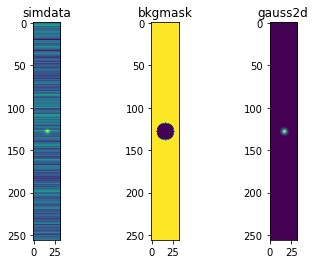

In [2]:
rab = test_phot_algorithms.rowAmpBacksub()
simDict = rab.sim_data()
rab.show_images()

## Now test the simulation with ROEBA applied
The plots are now
* "simdata" - the simulated data
* "bkgmask" - the mask of background pixels
* "gauss2d" - the Gaussian star alone
* "model" - the ROEBA model from background pixels
* "resid" - the residual of the ROEBA-applied image and the original Gaussian 2D

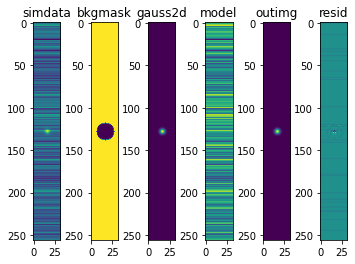

In [3]:
outimg, modelimg = rowamp_sub.do_backsub(simDict['simdata'],
                                         amplifiers=1,
                                         backgMask=simDict['bkgmask'])
simDict['model'] = modelimg
simDict['outimg'] = outimg
simDict['resid'] = simDict['gauss2d'] - simDict['outimg']

rab.show_images(simDict)


The residuals don't look perfect. But further examination shows they are within machine errors

In [4]:
np.max(np.abs((simDict['resid'])))

4.440892098500626e-16

## How to use it with the JWST pipeline?

You can run ROEBA after the superbias step like so.
This assumes you have already run the dq init and saturation flagging steps and called the result saturation


``` python
    from jwst.superbias import SuperBiasStep

    superbias_step = SuperBiasStep()
    # superbias_step.output_dir = output_dir
    # superbias_step.save_results = True
    
    # Call using the the output from the previously-run saturation step
    superbias = superbias_step.run(saturation)

    mod_refpix = deepcopy(superbias)
    
    ngroups = superbias.meta.exposure.ngroups
    nints = superbias.data.shape[0] ## could be split into ints per segment
    
    for oneInt in tqdm.tqdm(np.arange(nints)):
        for oneGroup in np.arange(ngroups):
            
            rowSub, modelImg = rowamp_sub.do_backsub(superbias.data[oneInt,oneGroup,:,:],
                                                     backgMask=simDict['bkgmask'],amplifiers=1)
            mod_refpix.data[oneInt,oneGroup,:,:] = rowSub
```